# Using Word2Vec Embedding to extend POC Guesser

We can use Gensim to make a more powerful version of our Proof-of-Concept. The main limitation will be guesses that lie outside of the training corpora; we might tackle this later with FastText. For now, let's see if we can make less of a toy version using the Google News Skip-Gram model with 300-feature embeddings (requires ~2GB).

Make sure to update SSL Certificate to download if required: 
```
pip install -U certifi

/Applications/Python 3.X/Install Certificates.command
```

In [1]:
import os
import gensim
import gensim.downloader
import gensim.models

saved_path_name = "word2vec-google-news-300_c"
limit = 200_000

if not os.path.exists(saved_path_name):
    print("Checking cache and downloading")
    google_news_wv = gensim.downloader.load("word2vec-google-news-300")
    google_news_wv.save_word2vec_format(saved_path_name)
    print("Saved to disk in C format")
    del google_news_wv

print(f"Loading {limit} from saved")
google_news_wv = gensim.models.KeyedVectors.load_word2vec_format(saved_path_name, limit=limit)

Loading 200000 from saved


In [2]:
print(len(google_news_wv.index_to_key))
for index, word in enumerate(google_news_wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(google_news_wv.index_to_key)} is {word}")

200000
word #0/200000 is </s>
word #1/200000 is in
word #2/200000 is for
word #3/200000 is that
word #4/200000 is is
word #5/200000 is on
word #6/200000 is ##
word #7/200000 is The
word #8/200000 is with
word #9/200000 is said


Let's see if the model has each of our official words

In [3]:
import decryptogame as dg

for word in dg.official_words.english.words:
    if word.lower() not in google_news_wv:
        print(word)

SCIENCE-FICTION
FRANCE
CYCLOPS
EGYPT
EXTRA-TERRESTRIAL
CALENDA
GERMANY
QUEBEC
PEGASUS
ARMOUR
CENTAUR
AFRICA
RUSSIA
SLAUGHTER-HOUSE
THEATRE
MOUSTACHE


I suspect this may just be a matter of capitalization, formatting, and British spellings. Let's see if we can make a mapping; if not we can use the weak linearity of Word2Vec. 

In [4]:
def official_keyword_to_word(keyword: str):
    typos = { "CALENDA": "calendar"}
    if keyword in typos:
        return typos[keyword]
    proper_nouns = [
        "AFRICA",
        "CENTAUR",
        "CYCLOPS",
        "EGYPT",
        "FRANCE",
        "GERMANY",
        "PEGASUS",
        "QUEBEC",
        "RUSSIA"
    ]
    if keyword in proper_nouns:
        return keyword.capitalize()
    british = {
        "ARMOUR": "armor",
        "MOUSTACHE": "mustache",
        "THEATRE": "theater",
    }
    if keyword in british:
        return british[keyword]
    if '-' in keyword:
        if keyword == "SCIENCE-FICTION":
            keyword = keyword.replace('-', '_')
        keyword = keyword.replace('-', '')
    return keyword.lower()

all_included = False
for keyword in dg.official_words.english.words:
    if official_keyword_to_word(keyword) not in google_news_wv:
        print(keyword)
        all_included = True
if not all_included:
    print("Gonna have to improvise")
print("Done!")





Gonna have to improvise
Done!


Looks like we don't need to improvise! Let's see what the keywords the creators chose look like using t-SNE

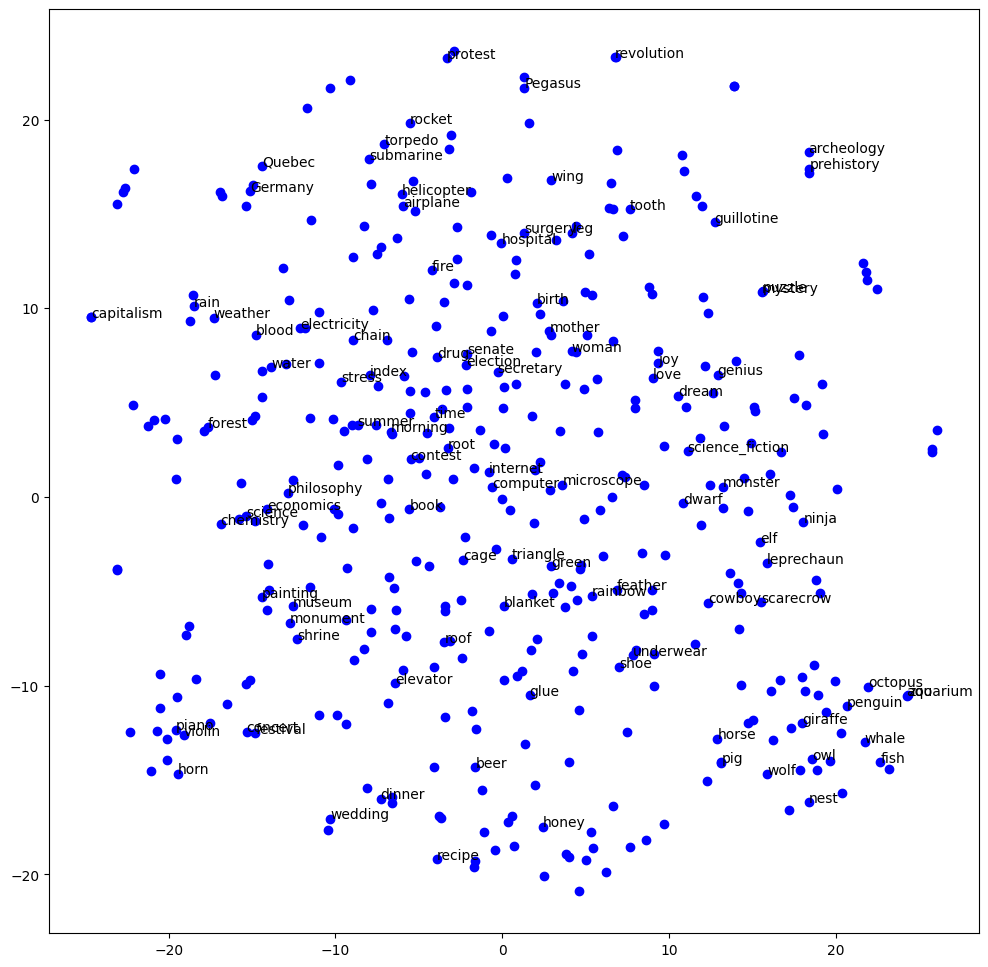

In [5]:
# inspired by https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py

from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling
import matplotlib.pyplot as plt
import random

random.seed(400)

official_words = [official_keyword_to_word(word) for word in dg.official_words.english.words]
official_vectors = np.asarray([google_news_wv[word] for word in official_words])

# reduce using t-SNE
num_dimensions = 2
tsne = TSNE(n_components=num_dimensions, random_state=0)
tsne_official_vectors = tsne.fit_transform(official_vectors)
official_x_vals, official_y_vals, *_ = zip(*tsne_official_vectors) # x has v[0] for each vector, y has v[1]

def plot_with_matplotlib(fig, ax, x_vals, y_vals, labels, num_show=100, color="b"):
    
    ax.scatter(x_vals, y_vals, color=color)

    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, num_show)
    for i in selected_indices:
        ax.annotate(labels[i], (x_vals[i], y_vals[i]))

fig, ax = plt.subplots(figsize=(12, 12))
plot_with_matplotlib(fig, ax, official_x_vals, official_y_vals, official_words)


How do the words compare to words in the general corpus? I predict it will be clustered because although they may have tried to choose dissimilar words, the words are almost all nouns and share a similar type; furthermore, the creators also probably didn't choose extremely rare words.

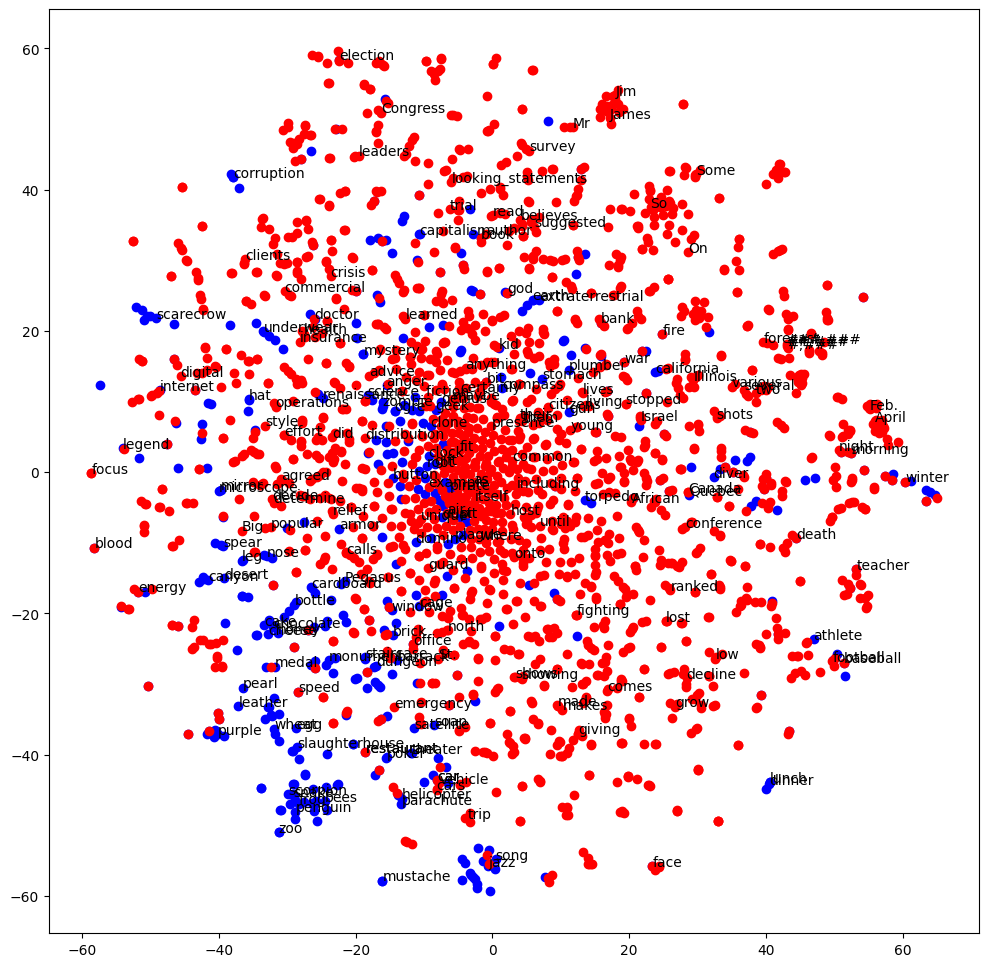

In [6]:

google_words = [word for word in google_news_wv.index_to_key[:2_000]]
google_vectors = np.asarray([google_news_wv[word] for word in google_words])

# reduce using t-SNE
tsne = TSNE(n_components=num_dimensions, random_state=0)
both_vectors = np.concatenate((official_vectors, google_vectors))
tsne_both_vectors = tsne.fit_transform(both_vectors)
x_vals, y_vals, *_ = zip(*tsne_both_vectors) # x has v[0] for each vector, y has v[1]
official_x_vals, official_y_vals = x_vals[:len(official_vectors)], y_vals[:len(official_vectors)]
google_x_vals, google_y_vals = x_vals[len(official_vectors):], y_vals[len(official_vectors):]

fig, ax = plt.subplots(figsize=(12, 12))
plot_with_matplotlib(fig, ax, official_x_vals, official_y_vals, official_words)
plot_with_matplotlib(fig, ax, google_x_vals, google_y_vals, google_words, color="r")

The words are actually a lot less clustered than I thought they would be.

The most striking thing is the sidedness; I think this corresponds to the prediction I made based off of the noun hypothesis, as evidenced by the lack of official words near verbs.

One interesting thing to notice is that a lot of words are separated from the official words by a large margin; perhaps such words could be used to highly throw off an opposing intercepter.
On the other hand, for official words that are outliers, using closely related words will leak a lot more information. Words like hockey seem a lot worse to get than scarecrow and doll because there are fewer similar official words to them.

Another interesting thing to notice is that the official words are actually less clumped than the most common words in the model; perhaps this asymmetry could be taken advantadge of? The main sources of clumping in the official words seem to be "animal" and "food" categories.

# Modelling a stronger Guesser

Now that we have a bit of a grasp on how the Google News Word2Vec model is compatible with our Decrypto words, let's build a stronger guesser. This will require us to generate a dataset of more sophisticated clues, and test some notions of probability we can extract from the model.

## Creating better clue datasets

To create some clues that are based on having similar meaning or based on words triggered by a codeword, we can use the [Datamuse API](https://www.datamuse.com/api/).

In [7]:
import json

import asyncio
import aiohttp

def datamuse_url(endpoint: str, words: list[str]): # can add stuff for prefix/suffix support later
    query_str = '+'.join(words)
    return f"https://api.datamuse.com/{endpoint}={query_str}"

async def fetch_text_response(session, url, return_id=None):
    # return ID let's us associate the result with a paramater
    # this allows us to know which word the reponse text is associated with
    # despite being called asynchronously
    async with session.get(url) as response:
        text = await response.text()
        return return_id, text

async def fetch_text_responses(urls, return_ids):
    async with aiohttp.ClientSession() as session:
        api_calls = [fetch_text_response(session, *args) for args in zip(urls, return_ids)]
        return [await response for response in asyncio.as_completed(api_calls)]

# process responses for local storage

def create_dataset_dict(responses):
    meaning_dataset = {}
    for word, response in responses:
        response_object = json.loads(response)
        legal_word_info = (word_info for word_info in response_object if word.lower() not in word_info["word"])
        legal_and_recognizeable = [word_info for word_info in legal_word_info if word_info["word"] in google_news_wv]
        meaning_dataset[word] = legal_and_recognizeable
    return meaning_dataset


meaning_dataset_path = "meaning.json"
triggerword_dataset_path = "trigger_word.json"

if not os.path.exists(meaning_dataset_path):
    print("Creating meaning dataset")

    meaning_urls = [datamuse_url("words?ml", [word]) for word in official_words]
    meaning_responses = await fetch_text_responses(meaning_urls, official_words)

    meaning_dataset = create_dataset_dict(meaning_responses)

    with open(meaning_dataset_path, 'w') as f:
        json.dump(meaning_dataset, f)

else:
    with open(meaning_dataset_path) as f:
        meaning_dataset = json.load(f)



if not os.path.exists(triggerword_dataset_path):
    print("Creating triggerword dataset")

    triggerword_urls = [datamuse_url("words?rel_trg", [word]) for word in official_words]
    triggerword_responses = await fetch_text_responses(triggerword_urls, official_words)

    triggerword_dataset = create_dataset_dict(triggerword_responses)

    with open(triggerword_dataset_path, 'w') as f:
        json.dump(triggerword_dataset, f)

else:
    with open(triggerword_dataset_path) as f:
        triggerword_dataset = json.load(f)

print("Done!")



Done!


Let's see if we can use the similar meaning and trigger word datasets to come up with reasonable clues that would be more of a challenge for our Guesser. That is, let's see if we can make clues that follow the rules and that I might be able to guess myself.

In [8]:
def clueword_from_dataset(datamuse_dataset, code_word, seed=400):
    candidate_words = []
    scores = []
    if not datamuse_dataset[code_word]:
        return "garbage"
    for word_info in datamuse_dataset[code_word]:
        candidate_words.append(word_info["word"])
        scores.append(word_info["score"])
    np_scores = np.asarray(scores)
    probabilities = np_scores / np.sum(np_scores)
    [clue] = random.Random(seed).choices(candidate_words, probabilities)
    return clue

def clue_from_code(datamuse_dataset, keyword_card, code):
    code_words = (official_keyword_to_word(keyword_card[i]) for i in code)
    return tuple(clueword_from_dataset(datamuse_dataset, word) for word in code_words)

[test_keyword_card] = next(dg.generators.RandomKeywordCards(card_lengths=[4], seed=200))
[test_code] = next(dg.generators.RandomCodes([test_keyword_card], seed=200))

print(test_keyword_card)
print(test_code)

meaning_clue = clue_from_code(meaning_dataset, test_keyword_card, test_code)
triggerword_clue = clue_from_code(triggerword_dataset, test_keyword_card, test_code)

print(meaning_clue)
print(triggerword_clue)


('WINTER', 'PATH', 'FESTIVAL', 'POISON')
(0, 1, 3)
('cold', 'travel', 'inflame')
('snow', 'eclipse', 'glands')


Let's finally build our Word2Vec guesser and compare some different probability schemes.

We'll start with some naive strategies that simply manipulate the cosine similarity. I expect these to perform poorly for 2 reasons.

One is that the cosine similarity doesn't really correspond to something probablistic, so in a way we are more just using it as a heuristic. This could backfire because it doesn't really take context or frequency into account.

Another more subtle reason is that the cosine similarity is symmetric. This implies that the probability of using a clue for a keyword is the same as the probability of using the keyword as a clue for the clue word if it was the keyword (that was a mouthful). We know from Baye's Theorem this isn't quite true, because it doesn't take the probabilities/frequencies of each individual word into account, nor the density of similar neighbors each word has in the vector space.

Importantly, let's not forget to use log probabilities/heuristics due to our design choice in Guesser Proof-Of-Concept.

In [9]:
import math

# naive heuristics

def log_square_cosine_similarity(clue, keyword):
    similarity = google_news_wv.similarity(clue, keyword)
    return 2 * math.log(abs(similarity))

def log_normalized_cosine_similarity(clue, keyword):
    similarity = google_news_wv.similarity(clue, keyword)
    normalized_similiarity = (1 + similarity) / 2
    return math.log(normalized_similiarity)




In [10]:
# compare heuristics
from dataclasses import dataclass
from functools import partial
from itertools import permutations
from random_variable_guesser import Guess, RandomVariable, max_log_expected_probability_guess

keyword_card_length = 4
clue_length = 3

@dataclass
class ClueCodePair:
    clue: tuple[str]
    code: tuple[int]


@dataclass
class ClueSet:
    keyword_card: tuple[str]
    cluecodepairs: list[ClueCodePair]

@dataclass
class Result:
    cluecodepair: ClueCodePair
    guess: Guess

@dataclass
class ResultSet:
    keyword_card: tuple[str]
    results: list[Result]


all_possible_codes = list(permutations(range(keyword_card_length), clue_length))

def generate_clue_set(clue_from_code_func, keyword_card, codes=all_possible_codes):
    cluecodepairs = [ClueCodePair(clue_from_code_func(keyword_card, code), code) for code in codes]
    return ClueSet(keyword_card, cluecodepairs)

num_clue_sets = 100

keyword_card_generator = dg.generators.RandomKeywordCards(card_lengths=[keyword_card_length], seed=200)
test_keyword_cards = [keyword_card for _, [keyword_card] in zip(range(num_clue_sets), keyword_card_generator)]

meaning_clue_from_code = partial(clue_from_code, meaning_dataset)
meaning_clue_sets = [generate_clue_set(meaning_clue_from_code, keyword_card) for keyword_card in test_keyword_cards]

triggerword_clue_from_code = partial(clue_from_code, triggerword_dataset)
triggerword_clue_sets = [generate_clue_set(triggerword_clue_from_code, keyword_card) for keyword_card in test_keyword_cards]

# len(all_possible_codes) * num_clue_sets =  total guesses for each dataset

def get_result_set(strat_func, clue_set: ClueSet) -> ResultSet:
    results = []
    random_vars = [RandomVariable({official_keyword_to_word(keyword): 0.0}) for keyword in clue_set.keyword_card]
    for cluecodepair in clue_set.cluecodepairs:
        guess = max_log_expected_probability_guess(strat_func, random_vars, cluecodepair.clue)
        results.append(Result(cluecodepair, guess))
    return ResultSet(clue_set.keyword_card, results)



for strat_func in [log_square_cosine_similarity, log_normalized_cosine_similarity]:
    print(strat_func.__name__)

    meaning_result_sets = [get_result_set(strat_func, meaning_clue_set) for meaning_clue_set in meaning_clue_sets]
    percent_correct = 100 * sum(result.guess.code == result.cluecodepair.code for result_set in meaning_result_sets for result in result_set.results) / (len(meaning_clue_sets) * len(all_possible_codes))
    print(f"meaning clue set correct guess correct: {percent_correct}%")

    triggerword_result_sets = [get_result_set(strat_func, meaning_clue_set) for meaning_clue_set in triggerword_clue_sets]
    percent_correct = 100 * sum(result.guess.code == result.cluecodepair.code for result_set in triggerword_result_sets for result in result_set.results) / (len(triggerword_clue_sets) * len(all_possible_codes))
    print(f"triggerword clue set percent correct: {percent_correct}%")

log_square_cosine_similarity
meaning clue set correct guess correct: 71.5%
triggerword clue set percent correct: 74.75%
log_normalized_cosine_similarity
meaning clue set correct guess correct: 73.25%
triggerword clue set percent correct: 75.75%


Our naive guessers are performing very well! If they were to be guessing randomly, or always producing the same code, we should expect that they only get about 1 in 24 correct, or about 4.17% correct! This is far better than I was expecting; we may be able to get a lot more performance with better heuristics.

A couple more probabilistic heuristics would be perhaps to take the cosine similarity as a proportion of similarity to all words in the dataset. Another might be to take the the number of words with a cosine distance from the keyword that is greater than the clue distance from the keyword as a proportion of all words in the dataset. Not only are these more probabilistic in nature, but the more subtle trait of being asymmetric in the previously described sense.

Tuning these metric with parameters that depend on frequency may also be of relevance. Since we don't have that data through Gensim, [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law) may be useful.

We should look into the naive guesser's performance a bit better, though. Does it have a false sense of confidence for incorrect guesses? Is it simililarly unsure about all of its guesses? Are the clues it is getting wrong reasonable to get wrong, or is there an obvious pattern that it is missing?